<a href="https://colab.research.google.com/github/2bar/2bar.github.io/blob/master/kaggle_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kaggle：Titanic問題

与えられた情報から、titanic号の死者と生存者を予測する問題となります。

本作業はgoogle colaboratory上での作業を想定しています

In [ ]:
# Numpy,Pandasをimport
import numpy as np
import pandas as pd

KaggleのサイトからTitanic問題についてのデータを前もってダウンロードしておきます。

In [ ]:
# titanicの trainデータとtestデータを読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

データの内容を確認

In [ ]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


データの増量、testデータとtrainデータに共通の処理をする為にデータを結合する

In [ ]:
data = pd.concat([train, test], sort=False)

結合したデータを確認

In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# データ数を確認
print(len(train), len(test), len(data))

891 418 1309


In [ ]:
# 欠損データを確認
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
# Sexを0と1に変換
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)

In [ ]:
# Embarkedを数字データへ変換
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [ ]:
# Fareは平均値で埋める
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

In [ ]:
# Ageについても欠損していないデータの中央値で埋める
data['Age'].fillna(data['Age'].median(), inplace=True)

特徴量の探索

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

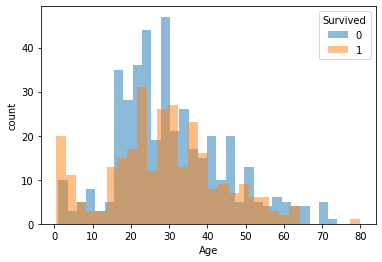

In [ ]:
# ageと目的変数の関係
plt.hist(train.loc[train['Survived'] == 0, 'Age'].dropna(), bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Age'].dropna(), bins=30, alpha=0.5, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived')
plt.show()

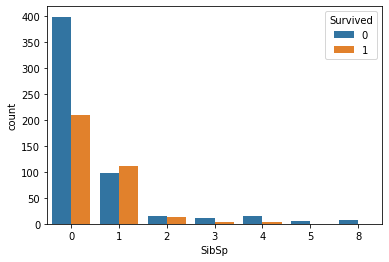

In [ ]:
# SibSp（同乗している兄弟、配偶者の数）と目的変数の関係
sns.countplot(x='SibSp', hue='Survived', data=train)
plt.legend(loc='upper right', title='Survived')
plt.show()

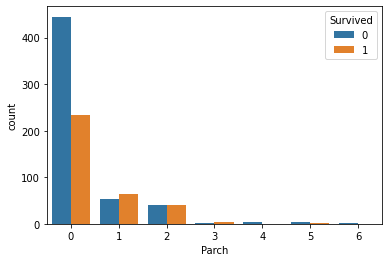

In [ ]:
# Parch（同乗している親、子供の数）と目的変数の関係
sns.countplot(x='Parch', hue='Survived', data=train)
plt.legend(loc='upper right', title='Survived')
plt.show()

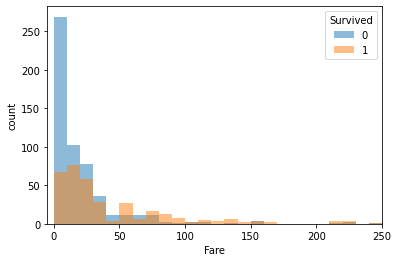

In [ ]:
# Fare（運賃）と目的変数の関係
plt.hist(train.loc[train['Survived'] == 0, 'Fare'].dropna(),
         range=(0, 250), bins=25, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Fare'].dropna(),
         range=(0, 250), bins=25, alpha=0.5, label='1')
plt.xlabel('Fare')
plt.ylabel('count')
plt.legend(title='Survived')
plt.xlim(-5, 250)
plt.show()

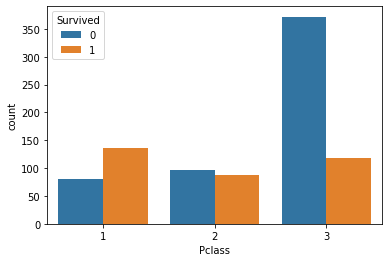

In [ ]:
# Pclass（客室）のクラスと目的変数の関係関係
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.show()

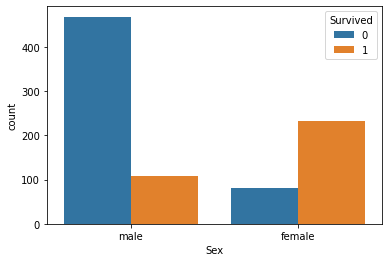

In [ ]:
# Sex（性別）と目的変数の関係
sns.countplot(x='Sex', hue='Survived', data=train)
plt.show()

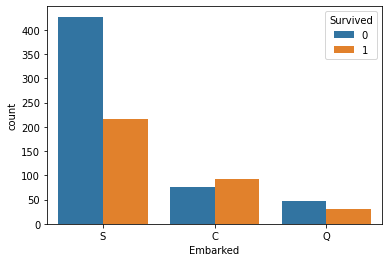

In [ ]:
# Embarked（出港地）と目的変数の関係
sns.countplot(x='Embarked', hue='Survived', data=train)
plt.show()

ParchとSibSpを合わせたFmilySizeという指標を新たに作る

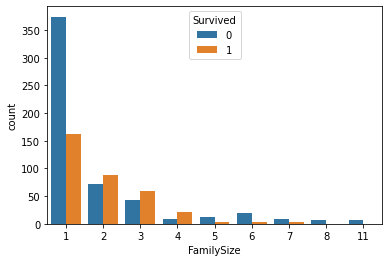

In [ ]:
import seaborn as sns

data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data = train, hue='Survived')

In [ ]:
# FamilySize==1についての新しい特徴量
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

In [ ]:
# 今回使わないパラメータを削除
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)

# 訓練データとテストデータを分ける
train = data[:len(train)]
test = data[len(train):]

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

In [ ]:
# 編集したデータ内容を確認
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,3,0,22.0,7.2500,0,2,0
1,1,1,38.0,71.2833,1,2,0
2,3,1,26.0,7.9250,0,1,1
3,1,1,35.0,53.1000,0,2,0
4,3,0,35.0,8.0500,0,1,1


RandomForestの導入

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
y_pred[:10]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
sub = pd.read_csv('gender_submission.csv')

In [ ]:
sub['Survived'] = list(map(int, y_pred))
sub.to_csv('submission_randomforest.csv', index=False)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


lightgbmの導入

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=0.3,
                                 random_state=0, stratify=y_train)

In [ ]:
# 可視化した時に相関があると推測されるデータをcategorical_featuresに設定
categorical_features = ['Embarked', 'Pclass', 'Sex']

In [ ]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train, y_train,
                                         categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,
                                         categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

model = lgb.train(params, lgb_train,
                               valid_sets=[lgb_train, lgb_eval],
                               verbose_eval=10,
                               num_boost_round=1000,
                               early_stopping_rounds=10)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.423733	valid_1's binary_logloss: 0.478405
[20]	training's binary_logloss: 0.349638	valid_1's binary_logloss: 0.443265
[30]	training's binary_logloss: 0.306276	valid_1's binary_logloss: 0.4325
[40]	training's binary_logloss: 0.272869	valid_1's binary_logloss: 0.437579
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.30244	valid_1's binary_logloss: 0.43101


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
y_pred[:10]

array([0.04743359, 0.47312467, 0.11632196, 0.07658649, 0.58028318,
       0.26812912, 0.69505433, 0.1127807 , 0.74625074, 0.05889494])

In [ ]:
# 値が0.5を上回っていると1とする
y_pred = (y_pred > 0.5).astype(int)
y_pred[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [ ]:
sub['Survived'] = y_pred
sub.to_csv('submission_lightgbm.csv', index=False)

sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


XGBoostの導入

In [ ]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier

kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
 
    
clf = xgb.XGBClassifier(random_state=1)
clf.fit(X_train,y_train)

y_pred_familysize_isalone_xgb = clf.predict(X_test)

sub['Survived'] = list(map(int, y_pred_familysize_isalone_xgb))
sub.to_csv('submission_familysize_isalone_XGB.csv', index=False)

sub.head()
    

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


アンサンブル学習

In [ ]:
import pandas as pd


sub_lgbm_sk = pd.read_csv('submission_lightgbm.csv')
sub_fam_al = pd.read_csv('submission_familysize_isalone_XGB.csv')
sub_rf = pd.read_csv('submission_randomforest.csv')

In [ ]:
sub_lgbm_sk.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
df = pd.DataFrame({'sub_lgbm_sk': sub_lgbm_sk['Survived'].values,
                                   'sub_fam_al': sub_fam_al['Survived'].values,
                                   'sub_rf': sub_rf['Survived'].values})
df.head()

,sub_lgbm_sk,sub_fam_al,sub_rf
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,1


In [ ]:
# 相関関係の可視化
df.corr()

,sub_lgbm_sk,sub_fam_al,sub_rf
sub_lgbm_sk,1.000000,0.848798,0.630788
sub_fam_al,0.848798,1.000000,0.694152
sub_rf,0.630788,0.694152,1.000000


In [ ]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = sub_lgbm_sk['Survived'] + sub_fam_al['Survived'] + sub_rf['Survived']
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,2


アンサンブル学習で得た結果を、多数決で決定

In [ ]:
sub['Survived'] = (sub['Survived'] >= 2).astype(int)
sub.to_csv('submission_titanic.csv', index=False)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


2020年10月2日現在　

score 0.79425 

順位：18686チーム中1261位

上位7％以内に入ることができました

参考

実践Data Scienceシリーズ PythonではじめるKaggleスタートブック　 著作　石原 祥太郎, 村田 秀樹

東京大学のデータサイエンティスト育成講座: Pythonで手を動かして学ぶデ―タ分析　　塚本邦尊 （著）,山田典一 （著）,大澤文孝 （著）,松尾豊（協力） （著）,中山浩太郎 （監修）

Kaggle の Titanic Prediction Competition でクラス分類（XGBoost、LightGBM、CatBoost編）
https://nehori.com/nikki/2019/12/22/post-14093/#XGBoost